***

# Embeddings

- By [Zachary Kilhoffer](https://zkilhoffer.github.io/)
- Updated 2024-06-17

***

### Description
- The code is part of the pipelines described in: 
  - Kilhoffer, Z. et al. (2024 in press). "Cloud Privacy Beyond Legal Compliance: An NLP analysis of certifiable privacy and security standards".
- The paper will be released on 2024-06-28 at the [IEEE Cloud Summit](https://www.ieeecloudsummit.org/2024-program).

***

- This is a pipeline to create embeddings from texts using a selection of pre-trained LLMs. 
- This can be handy to quickly compare/assess Topic Modeling results.
- For example, you can run a one-shot learning topic model pipeline using BERTopic for models A, B, and C, then visualize and compare results as needed.
- Note: The choice of dimensionality reduction technique also plays a big factor in the embeddings.

***

### Input files:
 - df = pd.read_excel('df_2023-12-16.xlsx')
 - reference_only_df = pd.read_excel('reference_only_df_2023-12-16.xlsx')

### Output files:
- 'df_embeddings_2023-12-16.xlsx'
- 'reference_only_df_embeddings_2023-12-16.xlsx'

***

In [1]:
import os, re, warnings, random
import pandas as pd
import numpy
import torch
import openpyxl
from transformers import BertTokenizer, BertModel, pipeline
from bertopic import BERTopic
# from fuzzywuzzy import fuzz, process
import nltk
from nltk.corpus import words
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import matplotlib
import matplotlib.pyplot as plt
from openai import OpenAI
from sentence_transformers import SentenceTransformer

c:\Users\zakki\topic modeling github rev\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

# Setup

In [10]:
# display tweaks
pd.set_option("display.max_colwidth", 200)  # how much text is showing within a cell
pd.set_option("display.max_columns", False)
pd.set_option("display.max_rows", False)
warnings.filterwarnings("ignore")

In [11]:
# load data
df = pd.read_excel('df_2023-12-16.xlsx')
reference_only_df = pd.read_excel('reference_only_df_2023-12-16.xlsx')

In [12]:
# inspect df
df.head(1)

,Unnamed: 0,control_category,control_code,control_name,control_text,page,document,control_text_corrected,full_control_text
0,0.0,organisation of information security (ois),OIS-01,information security management system (isms),basic criterion: the cloud service provider operates an information security management system (isms) in accordance with iso/iec 27001. the scope of the isms covers the cloud service provider’s or...,36.0,c5,Basic criterion: The cloud service provider operates an Information Security Management System (ISMS) in accordance with ISO/IEC 27001. The scope of the ISMS covers the cloud service provider's or...,Organisation of information security (ois). Information security management system (isms). Basic criterion: The cloud service provider operates an Information Security Management System (ISMS) in ...


In [13]:
# inspect reference only df
reference_only_df.head(1)

,Unnamed: 0,control_category,control_code,control_name,control_text,page,document,control_text_corrected,control_name_corrected,full_control_text
0,792,organizational controls,5.1,policies for information security,"control information security policy and topic-specific policies shall be defined, approved by management, published, communicated to and acknowledged by relevant personnel and relevant interested ...",16,iso_27001,"Control information security policy and topic-specific policies shall be defined, approved by management, published, communicated to, and acknowledged by relevant personnel and relevant interested...",Policies for Information Security.,"Organizational controls. Policies for information security. Control information security policy and topic-specific policies shall be defined, approved by management, published, communicated to, an..."


19


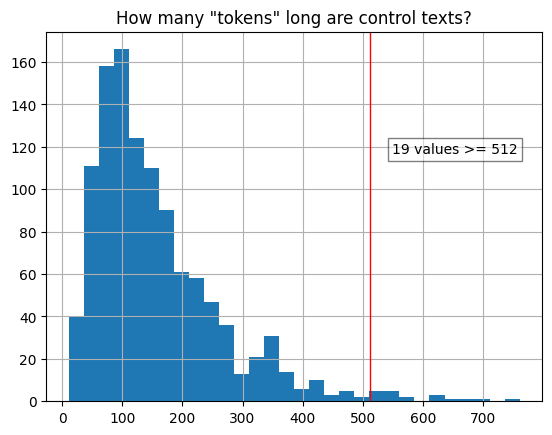

In [14]:
# How long are the texts? 
# Mostly much < 512 limit of BERT. 

l = df['full_control_text'].apply(lambda x: len(x.split(' ')))
z = len([x for x in l if x >= 512])
print(z)

ax = l.hist(bins=30)  # create histogram using axes object
ax.set_title('How many "tokens" long are control texts?')
plt.axvline(x=512, color='red', linewidth=1)
props = dict(boxstyle='square', facecolor='white', alpha=0.5)

ax.text(0.95, 0.7, f'{z} values >= 512', transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)
plt.show()

In [15]:
# create list for encoding
docs = list(df['full_control_text'].values)
docs_reference_only = list(reference_only_df['full_control_text'].values)

# BERT base

<div class="alert alert-block alert-warning">
<b>TO DO:</b> 

- Check if the length of tokens is a limitation here and what to do about it. 
- Check also if better model than bert-base-uncased/bert-large-uncased.
- No pretained privacy models were found on huggingface at present.
</div>


In [16]:
# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"  
model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

# function to do BERT embedding on text
def get_embedding(text):
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    output = model(**encoded_input)
    
    # Use the pooler output (representation of [CLS] token) and detach it to convert tensor to numpy
    embedding = output[1].detach().numpy()
    return embedding

df['BERTembeddings'] = df['full_control_text'].apply(get_embedding)
reference_only_df['BERTembeddings'] = reference_only_df['full_control_text'].apply(get_embedding)

# BERT large

In [17]:
# You can also experiment with the larger version of BERT if desired
model_name = "bert-large-uncased"
model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

df['BERTlargeembeddings'] = df['full_control_text'].apply(get_embedding)
reference_only_df['BERTlargeembeddings'] = reference_only_df['full_control_text'].apply(get_embedding)

# Ada2

In [20]:
# reads key.txt in the current directory for making API calls
def read_key_from_file(filename=r"key.txt"):  # replace with yours
    with open(filename, 'r') as file:
        return file.read().strip()

# setup client with your API key and organization
# replace 'YOUR_ORG_HERE' 
client = OpenAI(organization='YOUR_ORG_HERE', api_key=read_key_from_file())
    

In [30]:
# testing with short text
# creates embeddings if the setup worked properly
response = client.embeddings.create(
    input="Was mich nicht umbringt",
    model="text-embedding-ada-002"
)

# show result
print(response.data[0].embedding)

In [ ]:
# Creates embeddings by querying OpenAI for each text
# Make sure you understand how OpenAI charges you for API calls before running the whole thing!

# create embeddings column based on full_control_text column
df['ada2_embeddings'] = df['full_control_text'].apply(
    lambda text: client.embeddings.create(
        input=text, 
        model="text-embedding-ada-002"
    ).data[0].embedding
)

# all-mpnet-base-v2

Unlike BERT, all-mpnet-base-v2 is a sentence transformer suited for longer texts.

In [29]:
# make embeddings for main df
docs = list(df['full_control_text'].values)
sentence_model = SentenceTransformer("all-mpnet-base-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

In [ ]:
df['all-mpnet-base-v2_embeddings'] = embeddings.tolist()

In [43]:
# make embeddings for reference df
docs = list(reference_only_df['full_control_text'].values)
sentence_model = SentenceTransformer("all-mpnet-base-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

In [44]:
reference_only_df['all-mpnet-base-v2_embeddings'] = embeddings.tolist()

In [34]:
# embeddings not in same form (see last columns)
df.head(1)

,Unnamed: 0,control_category,control_code,control_name,control_text,page,document,control_text_corrected,full_control_text,BERTembeddings,BERTlargeembeddings,ada2_embeddings,all-mpnet-base-v2_embeddings
0,0.0,organisation of information security (ois),OIS-01,information security management system (isms),basic criterion: the cloud service provider operates an information security management system (isms) in accordance with iso/iec 27001. the scope of the isms covers the cloud service provider’s or...,36.0,c5,Basic criterion: The cloud service provider operates an Information Security Management System (ISMS) in accordance with ISO/IEC 27001. The scope of the ISMS covers the cloud service provider's or...,Organisation of information security (ois). Information security management system (isms). Basic criterion: The cloud service provider operates an Information Security Management System (ISMS) in ...,"[[-0.23476554, -0.22193438, -0.993742, 0.3670222, 0.8497376, -0.16401602, -0.6381365, -0.11291772, -0.9666921, -0.99915665, -0.7527634, 0.8858462, 0.110614575, 0.8264292, -0.5260503, -0.41770533, ...","[[-0.99997824, -0.9996931, 0.9999947, -0.99673074, -0.99972194, 0.99620223, -0.9999648, 0.99980146, 0.9931228, -0.99844056, -0.9996434, 0.99999297, -1.0, -0.9129203, 0.9927433, -0.99991816, -0.999...","[0.017099885269999504, -0.01439644955098629, 0.00117865193169564, -0.0317063108086586, -0.01916027069091797, 0.03131260722875595, -0.025590771809220314, -0.03850426897406578, 0.0047671012580394745...","[0.025447199121117592, -0.047563113272190094, -0.0010698908008635044, -0.02945668436586857, -0.05244108662009239, 0.0008069048053584993, 0.042670611292123795, 0.04808742180466652, -0.0093944948166..."


In [45]:
# embeddings not in same form (see last columns)
reference_only_df.head(1)

,Unnamed: 0,control_category,control_code,control_name,control_text,page,document,control_text_corrected,control_name_corrected,full_control_text,BERTembeddings,BERTlargeembeddings,ada2_embeddings,all-mpnet-base-v2_embeddings
0,792,organizational controls,5.1,policies for information security,"control information security policy and topic-specific policies shall be defined, approved by management, published, communicated to and acknowledged by relevant personnel and relevant interested ...",16,iso_27001,"Control information security policy and topic-specific policies shall be defined, approved by management, published, communicated to, and acknowledged by relevant personnel and relevant interested...",Policies for Information Security.,"Organizational controls. Policies for information security. Control information security policy and topic-specific policies shall be defined, approved by management, published, communicated to, an...","[[-0.7483474, -0.47950372, -0.9906762, 0.69624037, 0.8326306, -0.48163402, 0.3763824, 0.29337865, -0.95828897, -0.9999495, -0.79352665, 0.9742392, 0.85484904, 0.85074604, 0.33535042, -0.7259503, -...","[[-0.9773716, -0.9911405, 0.9997901, -0.9620378, -0.99899524, 0.6847769, -0.9994272, 0.99745417, 0.8713079, -0.9988649, -0.9956875, 0.9997872, -0.9999962, -0.0641057, 0.8665115, -0.9958053, -0.999...","[-0.005201301537454128, -0.025325844064354897, 0.015064510516822338, -0.030514303594827652, -0.014101306907832623, 0.009888894855976105, -0.008880740962922573, -0.009432977996766567, 0.00741024967...","[0.027031106874346733, -0.0008645474445074797, 0.015083176083862782, -0.02167108654975891, -0.061075322329998016, -0.036764826625585556, 0.049642447382211685, 0.02928995154798031, -0.0301633365452..."


In [40]:
# put embeddings in same form (simple list, not list of one element which is a list of embeddings)
df['BERTembeddings'] = df['BERTembeddings'].apply(lambda x: x[0])
df['BERTlargeembeddings'] = df['BERTlargeembeddings'].apply(lambda x: x[0])

In [46]:
# put embeddings in same form (simple list, not list of one element which is a list of embeddings)
reference_only_df['BERTembeddings'] = reference_only_df['BERTembeddings'].apply(lambda x: x[0])
reference_only_df['BERTlargeembeddings'] = reference_only_df['BERTlargeembeddings'].apply(lambda x: x[0])

In [47]:
# now all embeddings in correct form
df.head(1)

,Unnamed: 0,control_category,control_code,control_name,control_text,page,document,control_text_corrected,full_control_text,BERTembeddings,BERTlargeembeddings,ada2_embeddings,all-mpnet-base-v2_embeddings
0,0.0,organisation of information security (ois),OIS-01,information security management system (isms),basic criterion: the cloud service provider operates an information security management system (isms) in accordance with iso/iec 27001. the scope of the isms covers the cloud service provider’s or...,36.0,c5,Basic criterion: The cloud service provider operates an Information Security Management System (ISMS) in accordance with ISO/IEC 27001. The scope of the ISMS covers the cloud service provider's or...,Organisation of information security (ois). Information security management system (isms). Basic criterion: The cloud service provider operates an Information Security Management System (ISMS) in ...,"[-0.23476554, -0.22193438, -0.993742, 0.3670222, 0.8497376, -0.16401602, -0.6381365, -0.11291772, -0.9666921, -0.99915665, -0.7527634, 0.8858462, 0.110614575, 0.8264292, -0.5260503, -0.41770533, -...","[-0.99997824, -0.9996931, 0.9999947, -0.99673074, -0.99972194, 0.99620223, -0.9999648, 0.99980146, 0.9931228, -0.99844056, -0.9996434, 0.99999297, -1.0, -0.9129203, 0.9927433, -0.99991816, -0.9999...","[0.017099885269999504, -0.01439644955098629, 0.00117865193169564, -0.0317063108086586, -0.01916027069091797, 0.03131260722875595, -0.025590771809220314, -0.03850426897406578, 0.0047671012580394745...","[0.025447199121117592, -0.047563113272190094, -0.0010698908008635044, -0.02945668436586857, -0.05244108662009239, 0.0008069048053584993, 0.042670611292123795, 0.04808742180466652, -0.0093944948166..."


In [51]:
# now all embeddings in correct form
reference_only_df.head(1)

,Unnamed: 0,control_category,control_code,control_name,control_text,page,document,control_text_corrected,control_name_corrected,full_control_text,BERTembeddings,BERTlargeembeddings,ada2_embeddings,all-mpnet-base-v2_embeddings
0,792,organizational controls,5.1,policies for information security,"control information security policy and topic-specific policies shall be defined, approved by management, published, communicated to and acknowledged by relevant personnel and relevant interested ...",16,iso_27001,"Control information security policy and topic-specific policies shall be defined, approved by management, published, communicated to, and acknowledged by relevant personnel and relevant interested...",Policies for Information Security.,"Organizational controls. Policies for information security. Control information security policy and topic-specific policies shall be defined, approved by management, published, communicated to, an...","[-0.7483474, -0.47950372, -0.9906762, 0.69624037, 0.8326306, -0.48163402, 0.3763824, 0.29337865, -0.95828897, -0.9999495, -0.79352665, 0.9742392, 0.85484904, 0.85074604, 0.33535042, -0.7259503, -0...","[-0.9773716, -0.9911405, 0.9997901, -0.9620378, -0.99899524, 0.6847769, -0.9994272, 0.99745417, 0.8713079, -0.9988649, -0.9956875, 0.9997872, -0.9999962, -0.0641057, 0.8665115, -0.9958053, -0.9999...","[-0.005201301537454128, -0.025325844064354897, 0.015064510516822338, -0.030514303594827652, -0.014101306907832623, 0.009888894855976105, -0.008880740962922573, -0.009432977996766567, 0.00741024967...","[0.027031106874346733, -0.0008645474445074797, 0.015083176083862782, -0.02167108654975891, -0.061075322329998016, -0.036764826625585556, 0.049642447382211685, 0.02928995154798031, -0.0301633365452..."


In [49]:
# savings results
df.to_excel('../data/intermediate/df_embeddings_2023-12-16.xlsx')
reference_only_df.to_excel('../data/intermediate/reference_only_df_embeddings_2023-12-16.xlsx')